**Project 3**

Kuei-Tzu Hu 206300553

Sreya Muppalla 505675909

Christina Lee 406299676

In [1]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163001 sha256=2474329d8a331b20c076745ce6a011862fe7d961c9654356e88ea3e501f2eedb
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ECE ENGR 219/Synthetic_Movie_Lens

Mounted at /content/drive
/content/drive/My Drive/ECE ENGR 219/Synthetic_Movie_Lens


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
ratings = pd.read_csv("ratings.csv")
userId = ratings['userId'].values
movieId = ratings['movieId'].values
rating = ratings['rating'].values

In [6]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans

reader = Reader(line_format='user item rating timestamp', sep=',',skip_lines=1, rating_scale=(0.5, 5))
data = Dataset.load_from_file('ratings.csv', reader=reader)

###Question 8:


**A) Design a NMF-based collaborative filter to predict the ratings of the movies in the original
dataset and evaluate its performance using 10-fold cross-validation. Sweep k (number of
latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and
average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes
too long, you can increase the step size. Increasing it too much will result in poorer granularity
in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-
axis) against k (X-axis). For solving this question, use the default value for the regularization
parameter.**

In [ ]:
from surprise.prediction_algorithms.matrix_factorization import NMF

maeAvg = []
rmseAvg = []
#ADD MORE STEPS LATER
k = np.linspace(2,50,num=25,dtype=int)
for idx in k:
    print(idx)
    nmf = NMF(n_factors=idx)
    cv = cross_validate(nmf,data,cv=10)
    rmse_mean = np.mean(cv['test_rmse'])
    mae_mean = np.mean(cv['test_mae'])
    rmseAvg.append(rmse_mean)
    maeAvg.append(mae_mean)

Text(0.5, 1.0, 'NMF Collaborative Filter 10-fold CV')

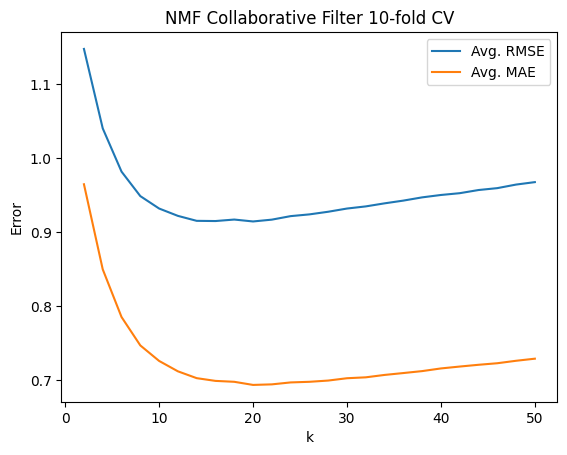

In [9]:
fig, ax = plt.subplots()
ax.plot(k,rmseAvg, label='Avg. RMSE')
ax.plot(k, maeAvg,label='Avg. MAE')
plt.xlabel("k")
plt.ylabel("Error")
plt.legend()
plt.title("NMF Collaborative Filter 10-fold CV")

**B) Use the plot from the previous part to find the optimal number of latent factors. Optimal
number of latent factors is the value of k that gives the minimum average RMSE or the
minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal
number of latent factors same as the number of movie genres?**

The optimal number of latent factors(26 for MAE and 14 for RMSE) is around the same as the number of movie genres(19).

In [10]:
comb_mae = list(zip(k,maeAvg))
comb_rmse = list(zip(k,rmseAvg))
min_mae = min(comb_mae, key = lambda t: t[1])
min_rmse = min(comb_rmse, key = lambda t: t[1])

print("Minimum average MAE: ", min_mae[1], " k: ", min_mae[0])
print("Minimum average RMSE: ", min_rmse[1], " k: ", min_rmse[0])

Minimum average MAE:  0.6932836558584488  k:  20
Minimum average RMSE:  0.9141154964129221  k:  20


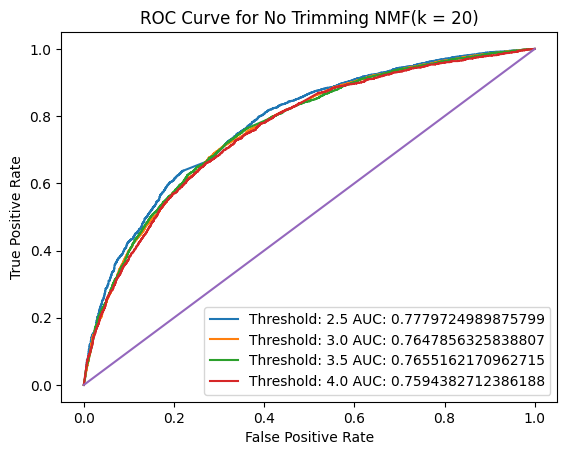

In [13]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
threshold_vals = [2.5, 3.0, 3.5, 4.0]
comb_rmse_pop = list(zip(k,rmseAvg))
min_rmse_pop = min(comb_rmse, key = lambda t: t[1])
train, test = train_test_split(data, test_size=0.1)
nmf = NMF(n_factors=min_rmse_pop[0])
nmf = nmf.fit(train)
nmf = nmf.test(test)
fig, ax = plt.subplots()
for threshold in threshold_vals:
    predicted = []
    for row in nmf:
        if row.r_ui <= threshold:
            predicted.append(0)
        else:
            predicted.append(1)
    actual = [row.est for row in nmf]
    fpr, tpr, thresholds = roc_curve(predicted, actual)
    tmpLabel = 'Threshold: ' + str(threshold) + " AUC: " + str(auc(fpr,tpr))
    ax.plot(fpr, tpr, label=tmpLabel)
ax.plot([0, 1], [0, 1])
title = 'ROC Curve for No Trimming NMF(k = ' + str(min_rmse_pop[0]) + ')'
plt.title(title)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**C) Performance on trimmed dataset subsets: For each of Popular, Unpopular and High-Variance subsets:**

- **Design a NMF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.**

- **Plot average RMSE (Y-axis) against k (X-axis). Report the minimum average RMSE.**

- **Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6**

In [ ]:
from surprise.model_selection import KFold
from surprise import accuracy

tracker = {}
for row in data.raw_ratings:
  if row[1] not in tracker:
    tracker[row[1]] = []
  tracker[row[1]].append(row[2])

#Popular
RMSENMFpop = []
kf =  KFold(n_splits=10)
for idx in k:
    currRMSE = []
    print(idx)
    for train, test in kf.split(data):
      trimTest = [row for row in test if len(tracker[row[1]]) > 2]
      nmf = NMF(n_factors=idx)
      nmf = nmf.fit(train)
      nmf = nmf.test(trimTest)
      currRMSE.append(accuracy.rmse(nmf))
    RMSENMFpop.append(np.mean(currRMSE))

In [15]:
print("Minimum Average RMSE:", min(RMSENMFpop))

Minimum Average RMSE: 0.8934364643638464


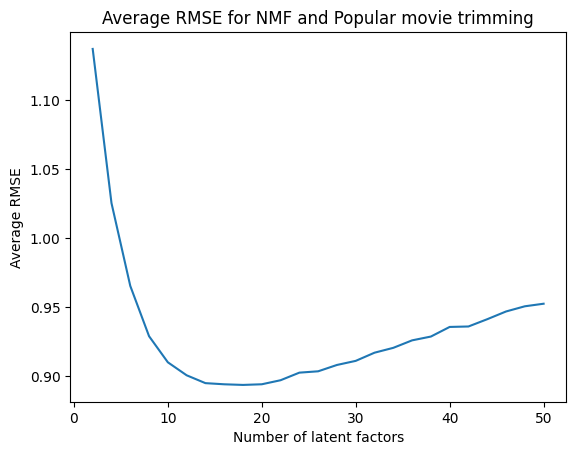

In [16]:
plt.plot(k,RMSENMFpop)
plt.title('Average RMSE for NMF and Popular movie trimming')
plt.ylabel('Average RMSE')
plt.xlabel('Number of latent factors')
plt.show()

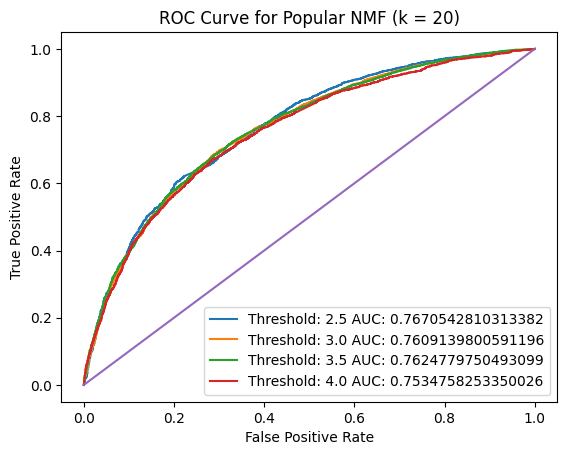

In [17]:
threshold_vals = [2.5, 3.0, 3.5, 4.0]
comb_rmse_pop = list(zip(k.tolist(),RMSENMFpop))
min_rmse_pop = min(comb_rmse, key = lambda t: t[1])
train, test = train_test_split(data, test_size=0.1)
nmf = NMF(n_factors=min_rmse_pop[0])
nmf = nmf.fit(train)
nmf = nmf.test(test)
fig, ax = plt.subplots()
for thresh in threshold_vals:
    predicted = []
    for row in nmf:
        if row.r_ui <= thresh:
            predicted.append(0)
        else:
            predicted.append(1)
    actual = [row.est for row in nmf]
    fpr, tpr, thresholds = roc_curve(predicted, actual)
    tmpLabel = 'Threshold: ' + str(thresh) + " AUC: " + str(auc(fpr,tpr))
    ax.plot(fpr, tpr, label=tmpLabel)
ax.plot([0, 1], [0, 1])
title = 'ROC Curve for Popular NMF (k = ' + str(min_rmse_pop[0]) + ')'
plt.title(title)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
#Unopular
RMSENMFunpop = []
kf =  KFold(n_splits=10)
for idx in k:
    currRMSE = []
    print(idx)
    for train, test in kf.split(data):
      trimTest = [row for row in test if len(tracker[row[1]]) <= 2]
      nmf = NMF(n_factors=idx)
      nmf = nmf.fit(train)
      nmf = nmf.test(trimTest)
      currRMSE.append(accuracy.rmse(nmf))
    RMSENMFunpop.append(np.mean(currRMSE))

In [19]:
print("Minimum Average RMSE:", min(RMSENMFunpop))

Minimum Average RMSE: 1.1710796049085808


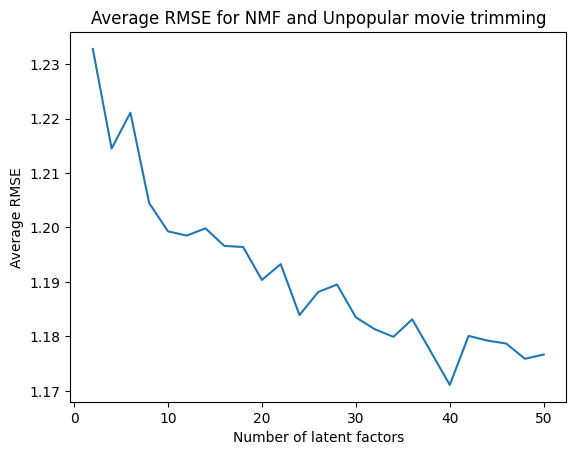

In [20]:
plt.plot(k,RMSENMFunpop)
plt.title('Average RMSE for NMF and Unpopular movie trimming')
plt.ylabel('Average RMSE')
plt.xlabel('Number of latent factors')
plt.show()

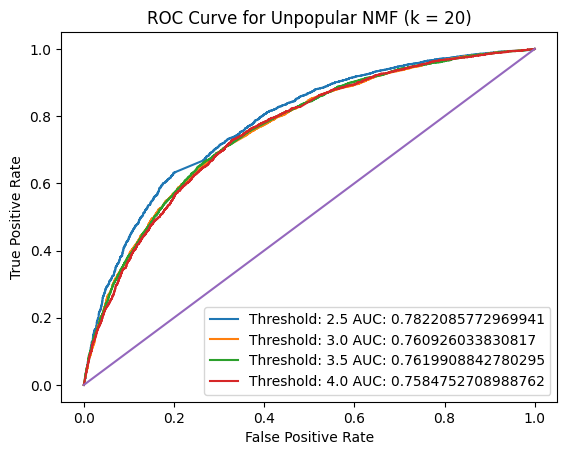

In [39]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
threshold_vals = [2.5, 3.0, 3.5, 4.0]
comb_rmse_pop = list(zip(k.tolist(),RMSENMFunpop))
min_rmse_pop = min(comb_rmse, key = lambda t: t[1])
train, test = train_test_split(data, test_size=0.1)
nmf = NMF(n_factors=min_rmse_pop[0])
nmf = nmf.fit(train)
nmf = nmf.test(test)
fig, ax = plt.subplots()
for thresh in threshold_vals:
    predicted = []
    for row in nmf:
        if row.r_ui <= thresh:
            predicted.append(0)
        else:
            predicted.append(1)
    actual = [row.est for row in nmf]
    fpr, tpr, thresholds = roc_curve(predicted, actual)
    tmpLabel = 'Threshold: ' + str(thresh) + " AUC: " + str(auc(fpr,tpr))
    ax.plot(fpr, tpr, label=tmpLabel)
ax.plot([0, 1], [0, 1])
title = 'ROC Curve for Unpopular NMF (k = ' + str(min_rmse_pop[0]) + ')'
plt.title(title)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [22]:
#High Variance
tracker = {}
for row in data.raw_ratings:
    if row[1] not in tracker:
      tracker[row[1]] = []
    tracker[row[1]].append(row[2])

In [ ]:
RMSENMFhivar = []
kf =  KFold(n_splits=10)
for idx in k:
    currRMSE = []
    print(idx)
    for train, test in kf.split(data):
      trimTest = [row for row in test if (len(tracker[row[1]]) >= 5 and np.var(tracker[row[1]]) >= 2)]
      nmf = NMF(n_factors=idx)
      nmf = nmf.fit(train)
      nmf = nmf.test(trimTest)
      currRMSE.append(accuracy.rmse(nmf))
    RMSENMFhivar.append(np.mean(currRMSE))

In [24]:
print("Minimum Average RMSE:", min(RMSENMFhivar))

Minimum Average RMSE: 1.5946200381286004


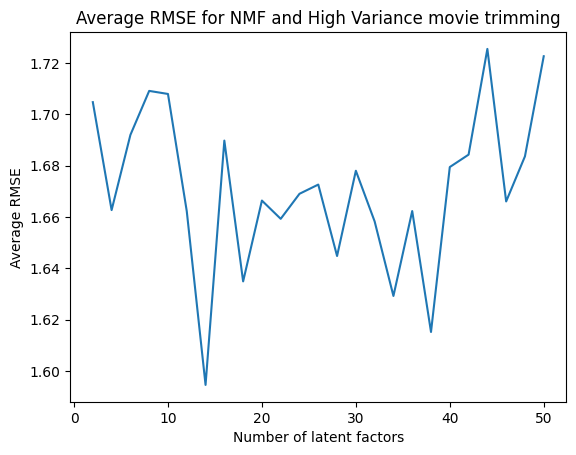

In [25]:
plt.plot(k,RMSENMFhivar)
plt.title('Average RMSE for NMF and High Variance movie trimming')
plt.ylabel('Average RMSE')
plt.xlabel('Number of latent factors')
plt.show()

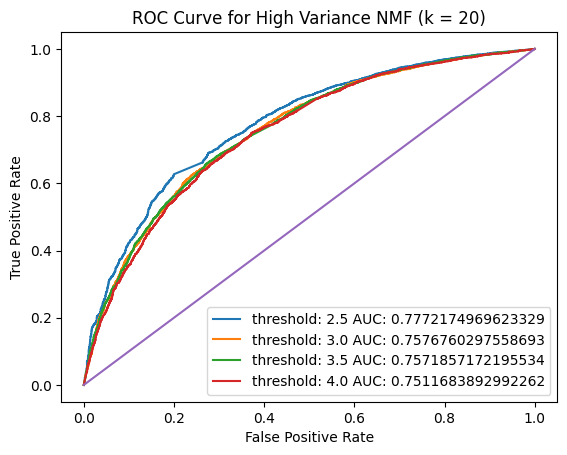

In [40]:
threshold_vals = [2.5, 3.0, 3.5, 4.0]
comb_rmse_hivar = list(zip(k,RMSENMFhivar))
min_rmse_hivar = min(comb_rmse, key = lambda t: t[1])
trainset, testset = train_test_split(data, test_size=0.1)
nmf = NMF(n_factors=min_rmse_hivar[0])
nmf = nmf.fit(train)
nmf = nmf.test(test)
fig, ax = plt.subplots()
for thresh in threshold_vals:
    predicted = []
    for row in nmf:
        if row.r_ui <= thresh:
            predicted.append(0)
        else:
            predicted.append(1)
    actual = [row.est for row in nmf]
    fpr, tpr, thresholds = roc_curve(predicted, actual)
    tmpLabel = 'threshold: ' + str(thresh) + " AUC: " + str(auc(fpr,tpr))
    ax.plot(fpr, tpr, label=tmpLabel)
ax.plot([0, 1], [0, 1])
title = 'ROC Curve for High Variance NMF (k = ' + str(min_rmse_hivar[0]) + ')'
plt.title(title)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

###Question 9

The output has the genres of the top 10 movies for each number of latent factors. As you can see, for all the latent factors, the top 10 movies belong to a small collection of genres. A pattern that arises is when the number of latent factors increases, the number of distinct movie genres decreases. This is because movie genres are clustered more the higher the number of latent factors is.

In [39]:
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF

train, test = train_test_split(data, test_size=.1)
df = pd.read_csv('movies.csv',names=['movieid','title','genres'])
df = df['genres']
nmf = NMF(n_factors=20)
nmf.fit(train)
nmf.test(test)
k = [0,4,8,12,16,19]
for i in k:
  print(i)
  tmp = nmf.qi[:,i]
  tmp2 = [(a,b) for a,b in enumerate(tmp)]
  tmp2.sort(key = lambda x:x[1], reverse=True)
  for idx in tmp2[:10]:
      print(df[idx[0]])

0
Drama
Action|Adventure|Fantasy|Sci-Fi
Drama|Mystery|Thriller
Action|Sci-Fi
Comedy
Action|Drama
Drama|Romance
Action
Action|Adventure|Sci-Fi
Action|Drama|IMAX
4
Comedy
Action
Drama
Drama|Romance
Action|Drama|War
Action|Crime
Comedy|Drama
Adventure|Comedy
Drama
Comedy|Drama
8
Comedy
Comedy|Drama
Comedy|Romance
Drama
Horror|Thriller
Children|Comedy
Comedy|Crime|Drama|Thriller
Comedy|Drama|Romance
Drama|Romance
Horror|Sci-Fi|Thriller
12
Adventure|Animation|Comedy
Drama|Mystery|Romance
Children|Comedy|Musical
Action|Crime|Drama|Thriller
Action|Drama|Sci-Fi|Thriller
Drama|Horror|Sci-Fi|Thriller
Action|Crime|Drama|Thriller
Thriller
Comedy
Action|Sci-Fi
16
Drama|War
Drama
Horror|Romance
Drama
Animation|Sci-Fi
Comedy|Drama
Thriller
Adventure|Children
Drama
Comedy|Drama|Romance
19
Romance
Crime|Drama
Drama
Comedy|Drama
Comedy|Crime
Comedy|Romance
Action|Drama|Sci-Fi|Thriller
Comedy
Sci-Fi
Comedy|Drama


###Question *10*


**A) Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
For solving this question, use the default value for the regularization parameter.**

In [ ]:
from surprise.prediction_algorithms.matrix_factorization import SVD
k = np.linspace(2,50,num=25,dtype=int)
maeAvg = []
rmseAvg = []
for idx in k:
    print(idx)
    svd = SVD(n_factors=idx)
    cv = cross_validate(svd,data,cv=10)
    rmse_mean = np.mean(cv['test_rmse'])
    mae_mean = np.mean(cv['test_mae'])
    rmseAvg.append(rmse_mean)
    maeAvg.append(mae_mean)

Text(0.5, 1.0, 'SVD Collaborative Filter 10-fold CV')

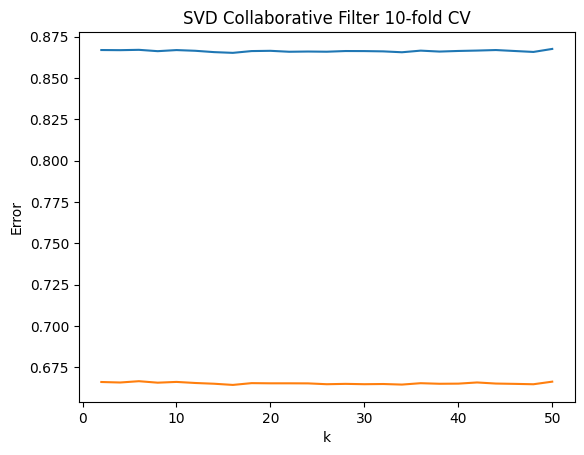

In [100]:
fig, ax = plt.subplots()
ax.plot(k,rmseAvg, label='Avg. RMSE')
ax.plot(k, maeAvg,label='Avg. MAE')
plt.xlabel("k");
plt.ylabel("Error");
plt.title("SVD Collaborative Filter 10-fold CV")

**B) Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?**

The minimum avg of both MAE and RMSE show that k=16. This is pretty close to the number of movie genres which is 19.

In [101]:
comb_mae = list(zip(k,maeAvg))
comb_rmse = list(zip(k,rmseAvg))
min_mae = min(comb_mae, key = lambda t: t[1])
min_rmse = min(comb_rmse, key = lambda t: t[1])

print("Minimum average MAE: ", min_mae[1], " k: ", min_mae[0])
print("Minimum average RMSE: ", min_rmse[1], " k: ", min_rmse[0])

Minimum average MAE:  0.6643649579801207  k:  16
Minimum average RMSE:  0.8651467248215328  k:  16


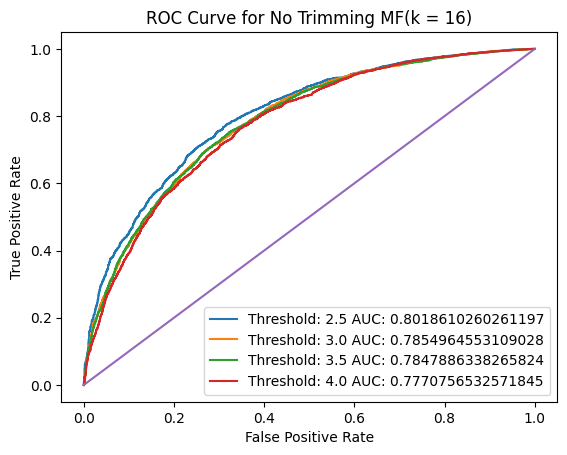

In [134]:
threshold_vals = [2.5, 3.0, 3.5, 4.0]
comb_rmse_pop = list(zip(k,rmseAvg))
min_rmse_pop = min(comb_rmse, key = lambda t: t[1])
train, test = train_test_split(data, test_size=0.1)
svd = SVD(n_factors=min_rmse_pop[0])
svd = svd.fit(train)
svd = svd.test(test)
fig, ax = plt.subplots()
for threshold in threshold_vals:
    predicted = []
    for row in svd:
        if row.r_ui <= threshold:
            predicted.append(0)
        else:
            predicted.append(1)
    actual = [row.est for row in svd]
    fpr, tpr, thresholds = roc_curve(predicted, actual)
    tmpLabel = 'Threshold: ' + str(threshold) + " AUC: " + str(auc(fpr,tpr))
    ax.plot(fpr, tpr, label=tmpLabel)
ax.plot([0, 1], [0, 1])
title = 'ROC Curve for No Trimming MF(k = ' + str(min_rmse_pop[0]) + ')'
plt.title(title)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**C) Performance on trimmed dataset subsets: For each of Popular, Unpopular and High-Variance subsets:**

- **Design a MF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.**

- **Plot average RMSE (Y-axis) against k (X-axis). Report the minimum average RMSE.**

- **Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.**

In [ ]:
from surprise.model_selection import KFold
from surprise import accuracy

tracker = {}
for row in data.raw_ratings:
  if row[1] not in tracker:
    tracker[row[1]] = []
  tracker[row[1]].append(row[2])

#Popular
RMSEMFpop = []
kf =  KFold(n_splits=10)
for idx in k:
    currRMSE = []
    print(idx)
    for train, test in kf.split(data):
      trimTest = [row for row in test if len(tracker[row[1]]) > 2]
      svd = SVD(n_factors=idx)
      svd = svd.fit(train)
      svd = svd.test(trimTest)
      currRMSE.append(accuracy.rmse(svd))
    RMSEMFpop.append(np.mean(currRMSE))

In [105]:
print("Minimum Average RMSE:", min(RMSEMFpop))

Minimum Average RMSE: 0.857810686086436


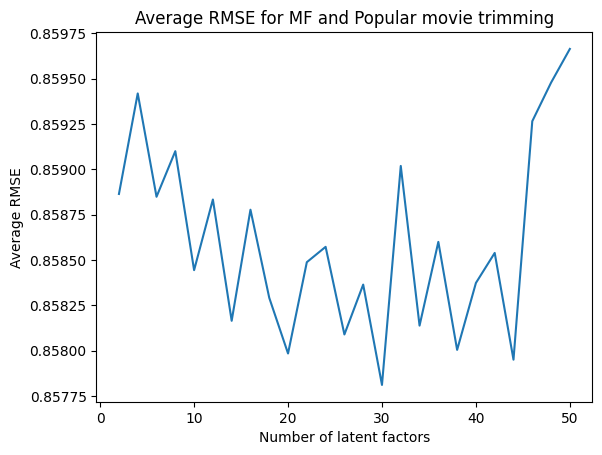

In [108]:
plt.plot(k,RMSEMFpop)
plt.title('Average RMSE for MF and Popular movie trimming')
plt.ylabel('Average RMSE')
plt.xlabel('Number of latent factors')
plt.show()

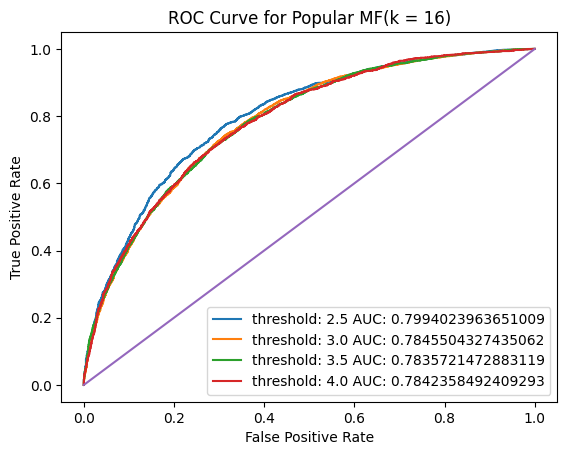

In [113]:
threshold_vals = [2.5, 3.0, 3.5, 4.0]
comb_rmse_pop = list(zip(k,RMSEMFpop))
min_rmse_pop = min(comb_rmse, key = lambda t: t[1])
train, test = train_test_split(data, test_size=0.1)
svd = SVD(n_factors=min_rmse_pop[0])
svd = svd.fit(train)
svd = svd.test(test)
fig, ax = plt.subplots()
for threshold in threshold_vals:
    predicted = []
    for row in svd:
        if row.r_ui <= threshold:
            predicted.append(0)
        else:
            predicted.append(1)
    actual = [row.est for row in svd]
    fpr, tpr, thresholds = roc_curve(predicted, actual)
    tmpLabel = 'Threshold: ' + str(threshold) + " AUC: " + str(auc(fpr,tpr))
    ax.plot(fpr, tpr, label=tmpLabel)
ax.plot([0, 1], [0, 1])
title = 'ROC Curve for Popular MF(k = ' + str(min_rmse_pop[0]) + ')'
plt.title(title)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
#Unpopular
RMSEMFunpop = []
kf =  KFold(n_splits=10)
for idx in k:
    currRMSE = []
    print(idx)
    for train, test in kf.split(data):
      trimTest = [row for row in test if len(tracker[row[1]]) <= 2]
      svd = SVD(n_factors=idx)
      svd = svd.fit(train)
      svd = svd.test(trimTest)
      currRMSE.append(accuracy.rmse(svd))
    RMSEMFunpop.append(np.mean(currRMSE))

In [115]:
print("Minimum Average RMSE:", min(RMSEMFunpop))

Minimum Average RMSE: 0.9698486551499339


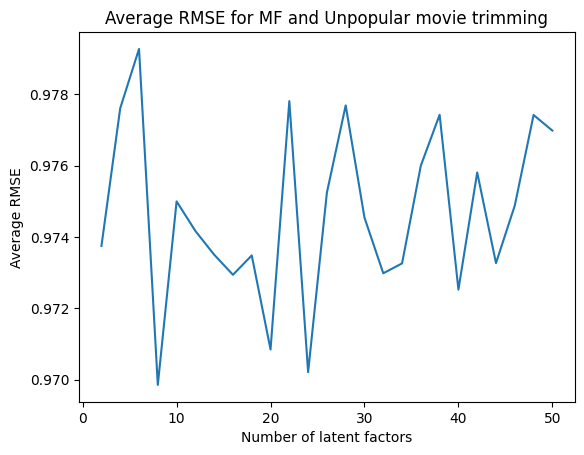

In [116]:
plt.plot(k,RMSEMFunpop)
plt.title('Average RMSE for MF and Unpopular movie trimming')
plt.ylabel('Average RMSE')
plt.xlabel('Number of latent factors')
plt.show()

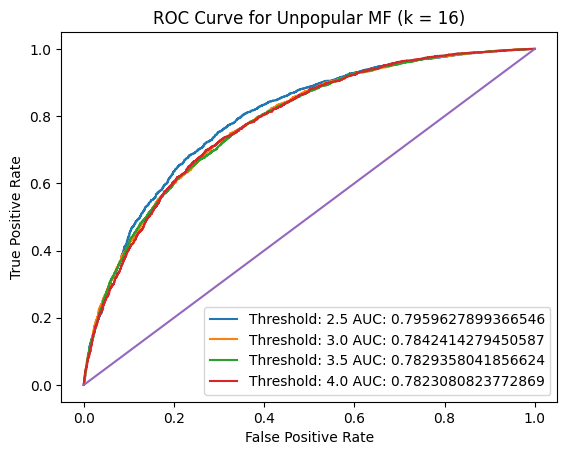

In [125]:
threshold_vals = [2.5, 3.0, 3.5, 4.0]
comb_rmse_unpop = list(zip(k,RMSEMFunpop))
min_rmse_unpop = min(comb_rmse, key = lambda t: t[1])
train, test = train_test_split(data, test_size=0.1)
svd = SVD(n_factors=min_rmse_unpop[0])
svd = svd.fit(train)
svd = svd.test(test)
fig, ax = plt.subplots()
for threshold in threshold_vals:
    predicted = []
    for row in svd:
        if row.r_ui <= threshold:
            predicted.append(0)
        else:
            predicted.append(1)
    actual = [row.est for row in svd]
    fpr, tpr, thresholds = roc_curve(predicted, actual)
    tmpLabel = 'Threshold: ' + str(threshold) + " AUC: " + str(auc(fpr,tpr))
    ax.plot(fpr, tpr, label=tmpLabel)
ax.plot([0, 1], [0, 1])
title = 'ROC Curve for Unpopular MF (k = ' + str(min_rmse_unpop[0]) + ')'
plt.title(title)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
#High Variance
RMSEMFhivar = []
kf =  KFold(n_splits=10)
for idx in k:
    currRMSE = []
    print(idx)
    for train, test in kf.split(data):
        trimTest = [row for row in test if (np.var(tracker[row[1]]) >= 2 and len(tracker[row[1]]) >= 5)]
        svd = SVD(n_factors=idx)
        svd = svd.fit(train)
        svd = svd.test(trimTest)
        currRMSE.append(accuracy.rmse(svd,verbose=False))
    RMSEMFhivar.append(np.mean(currRMSE))

In [128]:
print("Minimum Average RMSE:", min(RMSEMFhivar))

Minimum Average RMSE: 1.4186729308157928


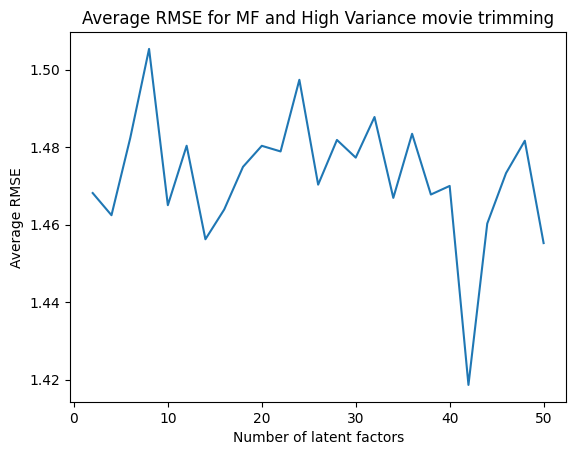

In [129]:
plt.plot(k,RMSEMFhivar)
plt.title('Average RMSE for MF and High Variance movie trimming')
plt.ylabel('Average RMSE')
plt.xlabel('Number of latent factors')
plt.show()

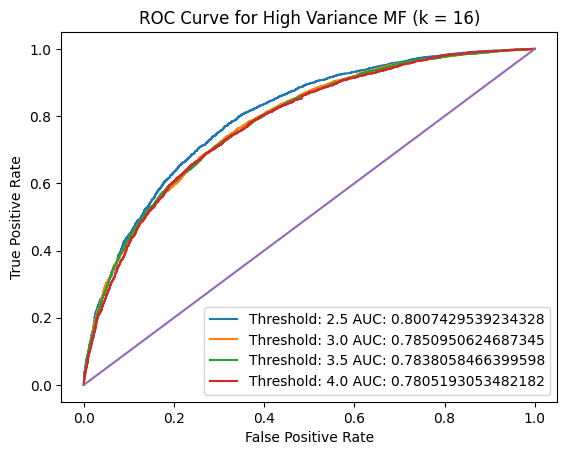

In [132]:
threshold_vals = [2.5, 3.0, 3.5, 4.0]
comb_rmse_hivar = list(zip(k,RMSEMFhivar))
min_rmse_hivar = min(comb_rmse, key = lambda t: t[1])
train, test = train_test_split(data, test_size=0.1)
svd = SVD(n_factors=min_rmse_hivar[0])
svd = svd.fit(train)
svd = svd.test(test)
fig, ax = plt.subplots()
for threshold in threshold_vals:
    predicted = []
    for row in svd:
        if row.r_ui <= threshold:
            predicted.append(0)
        else:
            predicted.append(1)
    actual = [row.est for row in svd]
    fpr, tpr, thresholds = roc_curve(predicted, actual)
    tmpLabel = 'Threshold: ' + str(threshold) + " AUC: " + str(auc(fpr,tpr))
    ax.plot(fpr, tpr, label=tmpLabel)
ax.plot([0, 1], [0, 1])
title = 'ROC Curve for High Variance MF (k = ' + str(min_rmse_hivar[0]) + ')'
plt.title(title)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

###Question *11*
**Design a naive collaborative filter to predict the ratings of the movies in the original dataset and evaluate it's performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.**

In [73]:
from sklearn.metrics import mean_squared_error
from surprise.model_selection import KFold
tracker = {}
for row in data.raw_ratings:
  if row[0] not in tracker:
    tracker[row[0]] = []
  tracker[row[0]].append(row[2])

user_tracker = {}
for idx in tracker:
  user_tracker[idx] = np.mean(tracker[idx])

In [74]:
rmse = []
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
  predicted = [user_tracker[i[0]] for i in testset]
  actual = [float(idx[2]) for idx in testset]
  rmse += [np.sqrt(mean_squared_error(actual,predicted))]
avg_rmse = np.mean(rmse)

print("Average RMSE for naive collaborative filter: ", avg_rmse)

Average RMSE for naive collaborative filter:  0.934690951896582


**Performance on dataset subsets: For each of Popular, Unpopular and High-Variance test subsets -**

**- Design a naive collaborative filter for each trimmed set and evaluate its performance using 10-fold cross validation.**

**- Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE**

In [82]:
#Popular
tracker1 = {}
for row in data.raw_ratings:
  if row[1] not in tracker1:
    tracker1[row[1]] = []
  tracker1[row[1]].append(row[2])

In [83]:
rmse = []
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
  popular = [row for row in testset if len(tracker1[row[1]]) > 2]
  predicted = [user_tracker[i[0]] for i in popular]
  actual = [idx[2] for idx in popular]
  rmse += [np.sqrt(mean_squared_error(actual,predicted))]
averageRmsePop = np.mean(rmse)

In [84]:
print('Avg. RMSE for Naive Filtering (Popular movie trimming): ',averageRmsePop)

Avg. RMSE for Naive Filtering (Popular movie trimming):  0.9322666805847106


In [85]:
#Unpopular
rmse = []
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
  popular = [row for row in testset if len(tracker1[row[1]]) <= 2]
  predicted = [user_tracker[i[0]] for i in popular]
  actual = [idx[2] for idx in popular]
  rmse += [np.sqrt(mean_squared_error(actual,predicted))]
averageRmseUnPop = np.mean(rmse)

In [86]:
print('Avg. RMSE for Naive Filtering (Unpopular movie trimming): ',averageRmseUnPop)

Avg. RMSE for Naive Filtering (Unpopular movie trimming):  0.9708290953335542


In [87]:
#High Variance
rmse = []
kf = KFold(n_splits=10)
for trainset, testset in kf.split(data):
  hivar = [row for row in testset if (len(tracker1[row[1]]) >= 5 and np.var(tracker1[row[1]]) >= 2)]
  predicted = [user_tracker[i[0]] for i in hivar]
  actual = [idx[2] for idx in hivar]
  rmse += [np.sqrt(mean_squared_error(actual,predicted))]
averageRmseHiVar = np.mean(rmse)

In [88]:
print('Avg. RMSE for Naive Filtering (Unpopular movie trimming): ',averageRmseHiVar)

Avg. RMSE for Naive Filtering (Unpopular movie trimming):  1.4659303344188763


###Question 12

**Comparing the most performant models across architecture: Plot the
best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.**

When threshold = 3, we can see that MF seems to perform the best at predicting the ratings of movies as it has a smoother curve and largest area under the curve. KNN seems to perform the next best and NMF seems to perform the worst.

In [28]:
train, test = train_test_split(data, test_size=.1)
threshold = 3
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [29]:
#KNN
knn = KNNWithMeans(k=20,sim_options={'name':'pearson'},verbose=False)
knn = knn.fit(train)
knn = knn.test(test)
actual = []
for i in knn:
  if i.r_ui <= threshold:
      actual.append(0)
  else:
      actual.append(1)
scores = [idx.est for idx in knn]
fpr_knn, tpr_knn, thresholds = roc_curve(actual, scores)

In [33]:
nmf = NMF(n_factors=20)
nmf = nmf.fit(train)
nmf = nmf.test(test)
actual = []
for i in nmf:
    if i.r_ui <= threshold:
      actual.append(0)
    else:
      actual.append(1)

scores = [i.est for i in nmf]
fpr_nmf, tpr_nmf, thresholds = roc_curve(actual, scores)

In [34]:
svd = SVD(n_factors=16)
svd = svd.fit(train)
svd = svd.test(test)
actual = []
for i in svd:
    if i.r_ui <= threshold:
      actual.append(0)
    else:
      actual.append(1)

scores = [i.est for i in svd]
fpr_svd, tpr_svd, thresholds = roc_curve(actual, scores)

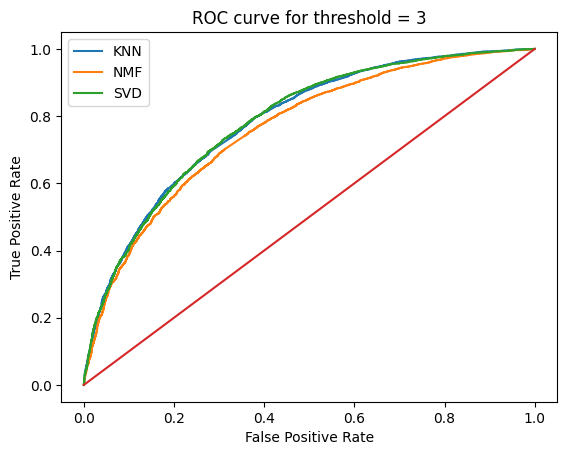

In [38]:
plt.plot(fpr_knn, tpr_knn,label="KNN")
plt.plot(fpr_nmf, tpr_nmf, label='NMF')
plt.plot(fpr_svd, tpr_svd, label='SVD')
plt.plot([0, 1], [0, 1])
plt.legend()
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.title('ROC curve for threshold = 3')
plt.show()